In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
from BNN_Dropout import NN_Dropout, BNN_Dropout
from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


 /home/alaya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


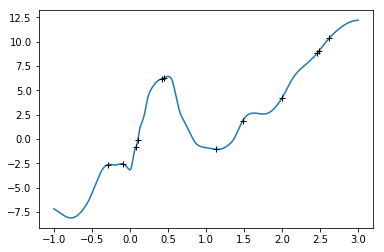

In [2]:
bench = RandomNN(1,3,50,nn.Tanh())
bench.rand_normal_weight(1)
num_plot  = 1000
num_train = 12
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x)
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [3]:
conf = dict()
conf['num_epochs'] = 5000
#conf['num_hidden'] = 50
#conf['num_layers'] = 3
#conf['batch_size'] = 1
#conf['lr'] = 1e-4
conf['tau'] = 1e-3
conf['dropout_rate'] = 0.05

model = BNN_Dropout(1,nn.Tanh(), conf)
hmc_model = Bohamiann(print_every_n_steps=100)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

In [4]:
hmc_model.train(train_x.numpy(), train_y.detach().numpy(), num_steps=3000, num_burn_in_steps=2000, keep_every=50, lr=1e-2, verbose=True)
model.train(train_x, train_y)
gp.optimize()

Step      100 : NLL =  7.1488e+02 MSE = 3.5271e+01 Time =  0.80
Step      200 : NLL =  9.1248e+02 MSE = 4.1797e+01 Time =  1.38
Step      300 : NLL =  1.1026e+03 MSE = 4.1562e+01 Time =  1.74
Step      400 : NLL =  1.3768e+03 MSE = 4.1874e+01 Time =  2.15
Step      500 : NLL =  1.7013e+03 MSE = 4.1408e+01 Time =  2.92
Step      600 : NLL =  2.1707e+03 MSE = 4.1950e+01 Time =  3.49
Step      700 : NLL =  2.6592e+03 MSE = 4.1694e+01 Time =  4.05
Step      800 : NLL =  3.2883e+03 MSE = 4.1697e+01 Time =  4.42
Step      900 : NLL =  4.1851e+03 MSE = 4.2102e+01 Time =  4.85
Step     1000 : NLL =  5.1243e+03 MSE = 4.1820e+01 Time =  5.22
Step     1100 : NLL =  6.2401e+03 MSE = 4.1625e+01 Time =  5.59
Step     1200 : NLL =  7.9387e+03 MSE = 4.1809e+01 Time =  5.95
Step     1300 : NLL =  9.8617e+03 MSE = 4.1990e+01 Time =  6.32
Step     1400 : NLL =  1.1868e+04 MSE = 4.1711e+01 Time =  6.92
Step     1500 : NLL =  1.4903e+04 MSE = 4.2377e+01 Time =  7.74
Step     1600 : NLL =  1.8517e+04 MSE = 

 /mnt/c/code/pybnn/pybnn/bohamiann.py:119: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step     2100 : NLL =  4.4193e+04 MSE = 4.2096e+01 Samples= 1 Time = 12.54
Step     2200 : NLL =  5.6548e+03 MSE = 4.1861e+01 Samples= 3 Time = 13.20
Step     2300 : NLL =  6.8812e+03 MSE = 4.1871e+01 Samples= 5 Time = 13.97
Step     2400 : NLL =  3.3736e+03 MSE = 4.1922e+01 Samples= 7 Time = 14.92
Step     2500 : NLL =  2.7575e+03 MSE = 4.1971e+01 Samples= 9 Time = 15.70
Step     2600 : NLL =  2.8848e+03 MSE = 4.1952e+01 Samples= 11 Time = 16.98
Step     2700 : NLL =  3.2535e+03 MSE = 4.1940e+01 Samples= 13 Time = 18.09
Step     2800 : NLL =  3.6299e+03 MSE = 4.1933e+01 Samples= 15 Time = 18.99
Step     2900 : NLL =  3.9826e+03 MSE = 4.1930e+01 Samples= 17 Time = 19.80
After 100 epochs, loss is 0.405706
After 200 epochs, loss is 0.373208
After 300 epochs, loss is 0.37634
After 400 epochs, loss is 0.38635
After 500 epochs, loss is 0.340802
After 600 epochs, loss is 0.368255
After 700 epochs, loss is 0.359182
After 800 epochs, loss is 0.348116
After 900 epochs, loss is 0.337658
After 10

Text(0.5,1,'Gaussian process')

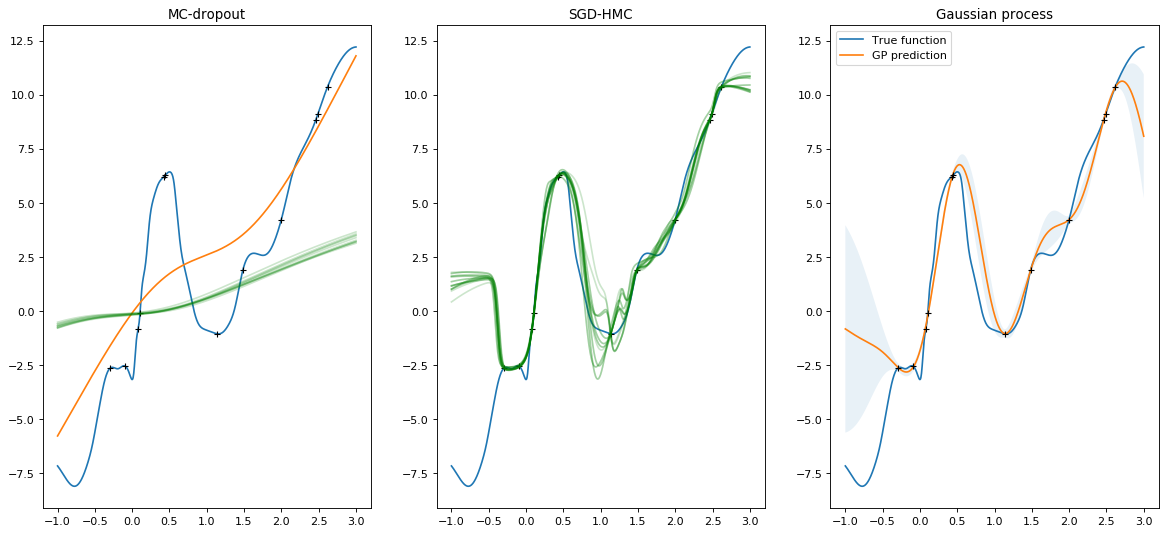

In [5]:
py = model.predict(x)
_,_,hmc_py = hmc_model.predict(x.numpy(), return_individual_predictions=True)
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(131)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
for i in range(10):
    net = model.sample()
    py  = net(x)
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.2)
plt.title('MC-dropout')

plt.subplot(132)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(), hmc_py.T, 'g', alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(133)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - np.sqrt(gp_v)).reshape(num_plot), (gp_m + np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')